In [1]:
from gurobipy import *
import gurobipy as gp

# type declaration
from typing import Dict, List


import pandas as pd
import numpy as np

# %load_ext nb_black
# %load_ext lab_black

In [2]:
df_distances = pd.read_csv(
    "/home/angelo/Documents/Uni/Courses/Management Science/MM_Code_repo/data/distances.csv"
)
df_pairs = pd.read_csv(
    "/home/angelo/Documents/Uni/Courses/Management Science/MM_Code_repo/data/pairs.csv"
)

#### Data Prep

In [3]:
unique_c1 = list(df_distances.city1.unique())

# possible combinations
for c in unique_c1:
    d1 = [c, c, 0]
    df_distances = df_distances.append(
        pd.Series(d1, index=["city1", "city2", "distance"]), ignore_index=True
    )

/tmp/ipykernel_3808/3893934404.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_distances = df_distances.append(
/tmp/ipykernel_3808/3893934404.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_distances = df_distances.append(
/tmp/ipykernel_3808/3893934404.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_distances = df_distances.append(
/tmp/ipykernel_3808/3893934404.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_distances = df_distances.append(
/tmp/ipykernel_3808/3893934404.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

In [4]:
df_pairs.loc[df_pairs.Dage == "-", "Dage"] = 99999999
df_pairs.Dage = df_pairs.Dage.astype(int)
df_pairs.loc[df_pairs.Rage == "-", "Rage"] = 99999999
df_pairs.Rage = df_pairs.Rage.astype(int)

df_pairs.loc[df_pairs.DBT == "-", "DBT"] = "NaN"
df_pairs.DBT = df_pairs.DBT.astype(str)
df_pairs.loc[df_pairs.RBT == "-", "RBT"] = "NaN"
df_pairs.RBT = df_pairs.RBT.astype(str)

In [5]:
# write the compatible bloodtypes
bloodtypes: Dict[str, int] = {
    # from A to everything
    ("A", "A"): 1,
    ("A", "B"): 0,
    ("A", "AB"): 1,
    ("A", "O"): 0,
    # from b to everything
    ("B", "A"): 0,
    ("B", "B"): 1,
    ("B", "AB"): 1,
    ("B", "O"): 0,
    # from AB to everything
    ("AB", "A"): 0,
    ("AB", "B"): 0,
    ("AB", "AB"): 1,
    ("AB", "O"): 0,
    # from O to everything
    ("O", "A"): 1,
    ("O", "B"): 1,
    ("O", "AB"): 1,
    ("O", "O"): 1,
    # missing blootypes
    ("NaN", "A"): 0,
    ("NaN", "B"): 0,
    ("NaN", "AB"): 0,
    ("NaN", "O"): 0,
    ("A", "NaN"): 0,
    ("B", "NaN"): 0,
    ("AB", "NaN"): 0,
    ("O", "NaN"): 0,
}

In [6]:
# change the order of the df to be more intuitive
RBT = df_pairs.loc[:, "RBT"]
DBT = df_pairs.loc[:, "DBT"]

# drop column
df_pairs.drop(columns=["RBT", "DBT"], axis=1, inplace=True)

# add them back
df_pairs["DBT"] = DBT
df_pairs["RBT"] = RBT

In [7]:
for i, r in df_pairs.iterrows():
    if (
        (df_pairs.iloc[i].type == "pair")
        & (
            abs(df_pairs.iloc[i].Rage.astype(int) - df_pairs.iloc[i].Dage.astype(int))
            <= 10
        )
        & (bloodtypes[(df_pairs.iloc[i].DBT, df_pairs.iloc[i].RBT)] == 1)
    ) == True:
        df_pairs.loc[i, "C"] = 1
    else:
        df_pairs.loc[i, "C"] = 0

### create arcs

In [8]:
def pos_city_sublist(location_):
    """_summary_

    Args:
        location_ (_type_): _description_

    Returns:
        _type_: _description_
    """
    return list(
        df_distances[
            (df_distances.city1.astype(str) == location_)
            & (df_distances.distance <= 300)
        ].city2.values
    )


def blood_types_rbt(RBT_):
    """_summary_

    Args:
        RBT_ (_type_): _description_

    Returns:
        _type_: _description_
    """
    valid_bloodtypes_receiver_tmp = []
    for k, v in bloodtypes.items():
        if (k[1] == RBT_) & (v == 1):
            valid_bloodtypes_receiver_tmp.append(k[0])

    return valid_bloodtypes_receiver_tmp


def blood_types_dbt(DBT_):
    """_summary_

    Args:
        DBT_ (_type_): _description_

    Returns:
        _type_: _description_
    """
    valid_bloodtypes_donor_tmp = []
    for k, v in bloodtypes.items():
        if (k[0] == DBT_) & (v == 1):
            valid_bloodtypes_donor_tmp.append(k[1])

    return valid_bloodtypes_donor_tmp

In [9]:
arcs_: Dict[tuple, list] = {}

for i, r in df_pairs.iterrows():
    id_ = df_pairs.iloc[i].ID
    type_ = df_pairs.iloc[i].type
    Rage_ = df_pairs.iloc[i].Rage
    Dage_ = df_pairs.iloc[i].Dage
    location_ = df_pairs.iloc[i].Location
    compatible_ = df_pairs.iloc[i].C
    RBT_ = df_pairs.iloc[i].RBT
    DBT_ = df_pairs.iloc[i].DBT

    # pairs
    if type_ == "pair":

        # create a subset of cities that are valid
        possible_cities1 = pos_city_sublist(location_)

        # for receivers, create a donor vloodtype list that contains all the blood types that are compartible
        valid_bloodtypes_receiver = blood_types_rbt(RBT_)

        # same but inverted the donor blood types
        valid_bloodtypes_donor = blood_types_dbt(DBT_)

        arcs_[("pair_receiver", id_)] = list(
            df_pairs[
                (df_pairs.Location.isin(possible_cities1))
                & (abs(df_pairs.Dage - Rage_) <= 10)
                & (df_pairs.DBT.isin(valid_bloodtypes_receiver))
            ].ID.values
        )

        arcs_[("pair_donor", id_)] = list(
            df_pairs[
                (df_pairs.Location.isin(possible_cities1))
                & (abs(df_pairs.Rage - Dage_) <= 10)
                & (df_pairs.RBT.isin(valid_bloodtypes_donor))
            ].ID.values
        )

    elif type_ == "receiver":
        # grap the city and only select those rows in "city1" where  the df_distances.city.astye(str) == location_
        # create a subset of cities that are valid
        possible_cities1 = pos_city_sublist(location_)

        # for receivers, create a donor vloodtype list that contains all the blood types that are compartible
        valid_bloodtypes_receiver = blood_types_rbt(RBT_)

        arcs_[("receiver", id_)] = list(
            df_pairs[
                (df_pairs.Location.isin(possible_cities1))
                & (abs(df_pairs.Dage - Rage_) <= 10)
                & (df_pairs.DBT.isin(valid_bloodtypes_receiver))
            ].ID.values
        )

    elif type_ == "donor":
        # grap the city and only select those rows in "city1" where  the df_distances.city.astye(str) == location_
        # create a subset of cities that are valid
        possible_cities1 = pos_city_sublist(location_)

        # same but inverted the donor blood types
        valid_bloodtypes_donor = blood_types_dbt(DBT_)

        arcs_[("donor", id_)] = list(
            df_pairs[
                (df_pairs.Location.isin(possible_cities1))
                & (abs(df_pairs.Rage - Dage_) <= 10)
                & (df_pairs.RBT.isin(valid_bloodtypes_donor))
            ].ID.values
        )

    else:
        print("warning")
        break

In [10]:
arcs_l = []
for k, v in arcs_.items():
    for i in range(len(v)):
        if k[0] in ["donor", "pair_donor"]:
            arcs_l.append((k[1], v[i]))

## Da model 

In [11]:
df_arcs = pd.DataFrame(arcs_l, columns =['donor', 'receiver']).reset_index()

In [12]:
donors_unique = []
receiver_unique = []
for possib in arcs_l:
    donors_unique.append(possib[0])
    receiver_unique.append(possib[1])
donors_unique = list(set(donors_unique))
receiver_unique = list(set(receiver_unique))

In [13]:
arc_donor = {}
for arc_k, arc_v in arcs_.items():
    if arc_k[1] in donors_unique:
        arc_donor[arc_k[1]] = arc_v
        
arc_receiver = {}
for arc_k, arc_v in arcs_.items():
    if arc_k[1] in donors_unique:
        arc_receiver[arc_k[1]] = arc_v

In [44]:
### Solving the model ###
# Initialize empty model and set model sense
model = gp.Model()
model.ModelSense = gp.GRB.MAXIMIZE

# Define variables
x=model.addVars(arcs_l, vtype=gp.GRB.BINARY, name="x")

# Set objective function
model.setObjective(gp.quicksum(x[(i[0],i[1])] for i in arcs_l))

# Add constraints
# for each donor there can only be in total one transfer for all elegible receivers (only one transfer)
for donor_or_pair_id in donors_unique:
    lhs = 0
    for pairing in arcs_l:
        if pairing[0] == donor_or_pair_id:
            lhs += x[pairing]
    model.addConstr(lhs <= 1, name="supply_d")

# for each receiver there can only be in total one transfer for all elegible donor (only one transfer)
for donor_or_pair_id in receiver_unique:
    lhs = 0
    for pairing in arcs_l:
        if pairing[1] == donor_or_pair_id:
            lhs += x[pairing]
    model.addConstr(lhs <= 1, name="demand_r")


# for all pairs there can only be one receiver if there is one donor if they are used to be transfered to some extend
model.addConstrs(((gp.quicksum(x[i,j] for j in list(df_arcs.loc[df_arcs["donor"]==i].receiver))) == 
                 (gp.quicksum(x[j,i] for j in list(df_arcs.loc[df_arcs["receiver"]==i].donor))) for i in list(df_pairs[df_pairs.type == "pair"].ID.values)),name="pair_dr")

# Optimize the model and print results    
model.optimize()   
print("Optimal value: ", model.objval)
model.printAttr(["X"])

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 369 rows, 896 columns and 2932 nonzeros
Model fingerprint: 0x34755998
Variable types: 0 continuous, 896 integer (896 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 45.0000000
Presolve removed 192 rows and 251 columns
Presolve time: 0.01s
Presolved: 177 rows, 645 columns, 2057 nonzeros
Found heuristic solution: objective 75.0000000
Variable types: 0 continuous, 645 integer (645 binary)

Root relaxation: objective 9.000000e+01, 167 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf |

In [45]:
x_ = x.copy()
output_dict = {}
for i_x, variable_o in zip(x, model.getVars()) :
    output_dict[i_x] = variable_o.x

output_dict_success = {}
for k,v  in output_dict.items():
    if v == 1:
        output_dict_success[k] = v


# B

In [46]:
receiver_id = []
for i in output_dict_success:
    receiver_id.append(i[1])

In [47]:
pair_id_final_received = []
receiver_id_final_received = []
for i in receiver_id:
    if i in list(df_pairs[df_pairs.type == "pair"].ID.values):
        pair_id_final_received.append(i)
    else:
        receiver_id_final_received.append(i)

In [48]:
print("receiver receiving", len(receiver_id_final_received)/len(list(df_pairs[df_pairs.type == "receiver"].ID)))
print("pairs receiving", len(pair_id_final_received)/len(list(df_pairs[df_pairs.type == "pair"].ID)))


# now to sum upt to 1
print('xxxxxxxxxxxxxxxxxxxxx')
print('below is incorrect!')
print("receiver receiving", len(receiver_id_final_received)/len(output_dict_success))
print("pairs receiving", len(pair_id_final_received)/len(output_dict_success))



receiver receiving 0.25
pairs receiving 0.7291666666666666
xxxxxxxxxxxxxxxxxxxxx
below is incorrect!
receiver receiving 0.2222222222222222
pairs receiving 0.7777777777777778


# donor + receiver 

### C

In [19]:
donor_dontated = []
for i in output_dict_success:
    if i[0] in list((df_pairs[df_pairs.type == "donor"]).ID.values):
        donor_dontated.append(i)

len(donor_dontated) / len(list((df_pairs[df_pairs.type == "donor"]).ID.values))

0.8333333333333334

### D

In [20]:
len(df_pairs[(df_pairs.ID.isin(pair_id_final_received))&(df_pairs.DBT!=df_pairs.RBT)].ID)/len(pair_id_final_received)

0.6

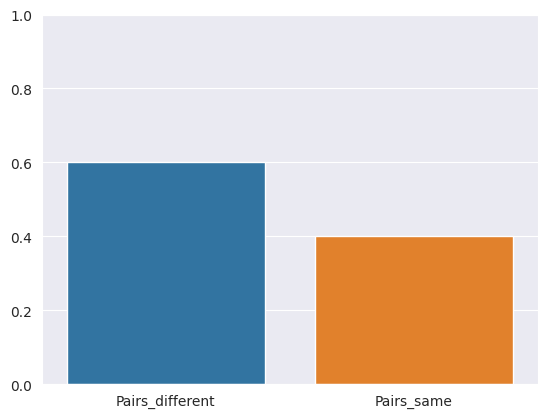

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

x = ['Pairs_different', 'Pairs_same']
y = [len(df_pairs[(df_pairs.ID.isin(pair_id_final_received))&(df_pairs.DBT!=df_pairs.RBT)].ID)/len(pair_id_final_received),
1 - len(df_pairs[(df_pairs.ID.isin(pair_id_final_received))&(df_pairs.DBT!=df_pairs.RBT)].ID)/len(pair_id_final_received)]

plt.ylim(0, 1)
sns.barplot(x = x, y = y)
plt.show()

In [22]:
paris_success_list = {}
for i in output_dict_success:
    if i[1] in (df_pairs[df_pairs["type"] == "pair"].ID.values):      
        paris_success_list[i] = (df_pairs[df_pairs.ID == i[0]].DBT.values[0] , df_pairs[df_pairs.ID == i[1]].RBT.values[0])
       

In [23]:
dict_count = {}
for k, v in paris_success_list.items():
    if v in dict_count.keys():
        dict_count[v] += 1
    elif v not in dict_count.keys():
        dict_count[v] = 1        

for k, v in bloodtypes.items():
    if (v == 1) and (k not in list(dict_count.keys())):
        dict_count[k] = 0  

In [24]:
all_pairs_bt = {}
for i, r in df_pairs[df_pairs.type == "pair"].iterrows():
    if ((r.DBT, r.RBT) not in list(all_pairs_bt.keys())) and (r.DBT, r.RBT) in list(dict_count.keys()):
        all_pairs_bt[(r.DBT, r.RBT)] = 1
    elif ((r.DBT, r.RBT) in list(all_pairs_bt.keys()) and (r.DBT, r.RBT) in list(dict_count.keys())):
        all_pairs_bt[(r.DBT, r.RBT)] += 1

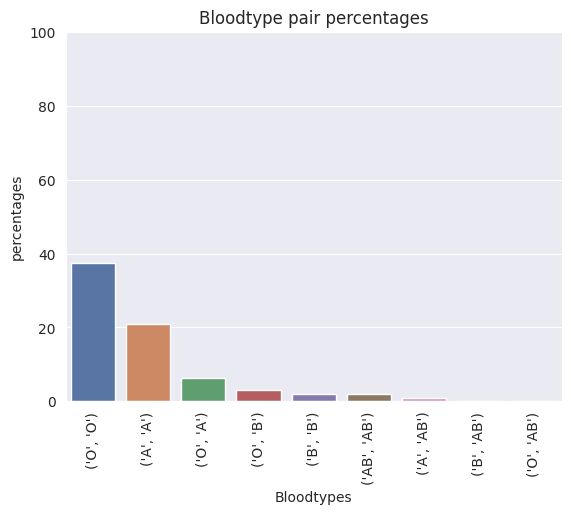

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')


l = list(dict_count.keys())
x = [str(x) for x in l]

l = list(dict_count.values())
y = [round((x / len(df_pairs[df_pairs.type  == "pair"].ID.values) * 100), 2) for x in l]

df_bloodtypes_converted = pd.DataFrame(zip(x, y), columns = ["Bloodtypes", "percentages"])
df_bloodtypes_converted.sort_values(by = "percentages", ascending = False, inplace = True)

plt.xticks(rotation=90)
plt.ylim(0,100)
plt.title("Bloodtype pair percentages")
sns.set(rc={'figure.figsize':(15,15)})

sns.barplot(data = df_bloodtypes_converted, x = "Bloodtypes", y = "percentages")
plt.show()

In [26]:
for i, v in dict_count.items():
    print("bloodtype:", i, "percentage:", round(v/len(df_pairs[df_pairs.type  == "pair"].ID.values)*100, 2), "%")

bloodtype: ('O', 'A') percentage: 6.25 %
bloodtype: ('O', 'B') percentage: 3.12 %
bloodtype: ('O', 'O') percentage: 37.5 %
bloodtype: ('B', 'B') percentage: 2.08 %
bloodtype: ('A', 'A') percentage: 20.83 %
bloodtype: ('AB', 'AB') percentage: 2.08 %
bloodtype: ('A', 'AB') percentage: 1.04 %
bloodtype: ('B', 'AB') percentage: 0.0 %
bloodtype: ('O', 'AB') percentage: 0.0 %


In [27]:
received_overall = []
for k in list(output_dict_success.keys()):
    received_overall.append(k[1])

df_temp_received = df_pairs[((df_pairs.type == "pair") & (df_pairs.ID.isin(received_overall)))]
df_temp_overall = df_pairs[((df_pairs.type == "pair"))]

In [28]:
df_temp_received["blood_combo"] = df_temp_received.loc[:,["DBT", "RBT"]].apply(tuple, axis=1)
df_temp_overall["blood_combo"] = df_temp_overall.loc[:,["DBT", "RBT"]].apply(tuple, axis=1)

/tmp/ipykernel_3808/3106095296.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_received["blood_combo"] = df_temp_received.loc[:,["DBT", "RBT"]].apply(tuple, axis=1)
/tmp/ipykernel_3808/3106095296.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp_overall["blood_combo"] = df_temp_overall.loc[:,["DBT", "RBT"]].apply(tuple, axis=1)


In [29]:
df1= df_temp_overall.groupby("blood_combo").agg({"blood_combo": "count"})
df2= df_temp_received.groupby("blood_combo").agg({"blood_combo": "count"})

In [30]:
df = pd.merge(left = df2, right= df1, left_index = True, right_index = True, how = "left").rename(columns = {"blood_combo_x":"count_received", "blood_combo_y":"count_total"})

df["proportion"] = df["count_received"] / df["count_total"]



In [31]:
df

,count_received,count_total,proportion
blood_combo,,,
"(A, A)",7,7,1.000000
"(A, AB)",1,1,1.000000
"(A, B)",2,4,0.500000
"(A, O)",15,21,0.714286
"(AB, A)",1,2,0.500000
"(AB, AB)",1,2,0.500000
"(B, A)",2,6,0.333333
"(B, O)",1,8,0.125000
"(O, A)",16,17,0.941176


## E

In [116]:
df_pairs_that_received_by_city = df_pairs[df_pairs.ID.isin(pair_id_final_received)].groupby(by =["Location"]).agg({"ID":"count"}).rename(columns = {"ID": "count_received"})

df_pairs_ = df_pairs[df_pairs.type == "pair"]
df_pairs_not_received = df_pairs_[~df_pairs_.ID.isin(pair_id_final_received)].groupby(by =["Location"]).agg({"ID":"count"}).rename(columns = {"ID": "count_not_received"})

In [117]:
df_combined = pd.merge(left = df_pairs_that_received_by_city, right = df_pairs_not_received, left_index = True, right_index = True, how = "left")
df_combined = df_combined.fillna(0)


df_combined["total"] = df_combined["count_received"] + df_combined["count_not_received"]

In [118]:
df_combined['proportion'] = df_combined["count_received"] / df_combined["total"]

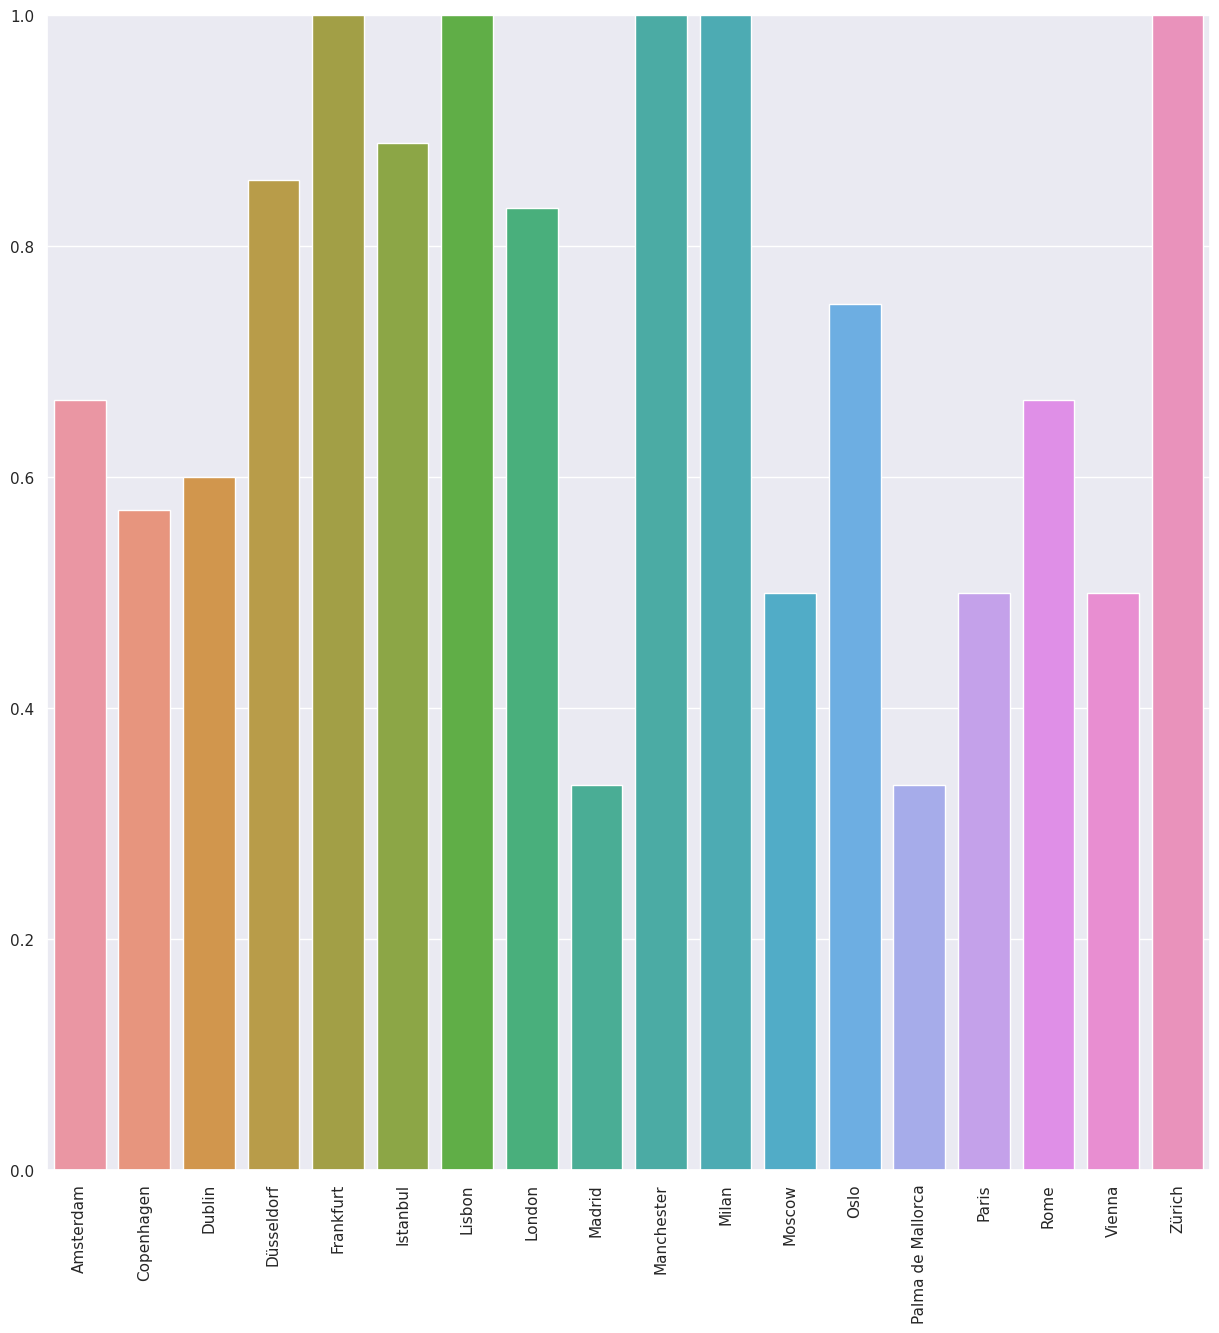

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

x = list(df_combined.index)
y = list(df_combined.proportion)

plt.xticks(rotation=90)
plt.ylim(0, 1)
sns.barplot(x = x, y = y)
plt.show()

In [122]:
df_combined.proportion

Location
Amsterdam            0.666667
Copenhagen           0.571429
Dublin               0.600000
Düsseldorf           0.857143
Frankfurt            1.000000
Istanbul             0.888889
Lisbon               1.000000
London               0.833333
Madrid               0.333333
Manchester           1.000000
Milan                1.000000
Moscow               0.500000
Oslo                 0.750000
Palma de Mallorca    0.333333
Paris                0.500000
Rome                 0.666667
Vienna               0.500000
Zürich               1.000000
Name: proportion, dtype: float64

## Partt 2


In [37]:
# activeArcs is the list with 94!!! just from the output 
def computePaths(arcs):
    paths = [[arc] for arc in arcs]
    join = True
    while(join):
        join=False
        for i,p1 in enumerate(paths):
            if join==True:
                break
            for j, p2 in enumerate(paths):
                if i<j:
                    if p1[-1][1] == p2[0][0]:
                        p2=paths.pop(j)
                        paths[i]=paths[i]+p2
                        join=True
                    elif p1[0][0]==p2[-1][1]:
                        p2=paths.pop(j)
                        paths[i]=p2+paths[i]
                        join=True
    return paths

activearcs = list(output_dict_success.keys())   
chains = computePaths(activearcs)

### Part 2 Q1

In [38]:
#define the function#
def find_max_list(list):
    list_len = [len(i) for i in list]
    return (max(list_len))


#print output#
print("A chain of length:" , find_max_list(computePaths(activearcs)))

max(computePaths(activearcs), key=len)


A chain of length: 9


[(186, 111),
 (111, 46),
 (46, 94),
 (94, 159),
 (159, 104),
 (104, 145),
 (145, 103),
 (103, 167),
 (167, 49)]

## Part 2 Q2

In [39]:
def subpath_chains_compute(input):  
    long_chains = []
    for i in input:
        if len(i) > max_length_chain:
            long_chains.append(i)

    sub_paths = []
    for chain_ in long_chains:
        for i in range(len(chain_)-max_length_chain):
            sub_paths.append(chain_[i:i+max_length_chain+1])
            
    return (sub_paths, long_chains)

In [40]:
# spec max length chain
max_length_chain = 3

model = gp.Model()
model.ModelSense = gp.GRB.MAXIMIZE

# Define variables
x=model.addVars(donors_unique,receiver_unique, vtype=gp.GRB.BINARY, name="x")

# Set objective function
model.setObjective(gp.quicksum(x[(i[0],i[1])] for i in arcs_l))

# Add constraints
# for each donor there can only be in total one transfer for all elegible receivers (only one transfer)
for donor_or_pair_id in donors_unique:
    lhs = 0
    for pairing in arcs_l:
        if pairing[0] == donor_or_pair_id:
            lhs += x[pairing]
    model.addConstr(lhs <= 1, name="supply_d")

# for each receiver there can only be in total one transfer for all elegible donor (only one transfer)
for donor_or_pair_id in receiver_unique:
    lhs = 0
    for pairing in arcs_l:
        if pairing[1] == donor_or_pair_id:
            lhs += x[pairing]
    model.addConstr(lhs <= 1, name="demand_r")


# for all pairs there can only be one receiver if there is one donor if they are used to be transfered to some extend
model.addConstrs(((gp.quicksum(x[i,j] for j in list(df_arcs.loc[df_arcs["donor"]==i].receiver))) == 
                 (gp.quicksum(x[j,i] for j in list(df_arcs.loc[df_arcs["receiver"]==i].donor))) for i in list(df_pairs[df_pairs.type == "pair"].ID.values)),name="pair_dr")

# while loop though chain until no further improvement is possible
while True:   
    """
    This is code from the 4th/5th weeks tutorial 
    """
    model.Params.LogToConsole = 0
    
    model.optimize()

    s_chains = subpath_chains_compute(computePaths([key for key, value in x.items() if value.X == 1]))

    # based on each subchain make sure that all comply with max_length_chain; add the constraints
    for subchain in s_chains[0]:
        model.addConstr(gp.quicksum(x[i] for i in subchain) <= max_length_chain)
    
    if len(s_chains[1]) == 0:
        break


In [41]:
model.Params.LogToConsole = 1

Set parameter LogToConsole to value 1


In [42]:
model.Params.LogToConsole = 1
model.printAttr('X')
print(model.ObjVal)


    Variable            X 
-------------------------
     x[4,30]            1 
      x[8,8]            1 
    x[10,97]            1 
   x[14,191]            1 
    x[20,93]            1 
   x[21,182]            1 
    x[29,29]            1 
   x[30,133]            1 
   x[31,103]            1 
    x[32,32]            1 
    x[34,34]            1 
   x[35,102]            1 
    x[36,60]            1 
   x[40,180]            1 
   x[41,194]            1 
    x[42,82]            1 
   x[45,118]            1 
   x[46,167]            1 
    x[54,40]            1 
   x[55,197]            1 
    x[58,58]            1 
   x[60,162]            1 
    x[61,89]            1 
   x[63,138]            1 
    x[64,84]            1 
   x[67,115]            1 
   x[68,113]            1 
    x[73,73]            1 
   x[81,146]            1 
   x[82,148]            1 
    x[84,87]            1 
   x[85,110]            1 
   x[87,151]            1 
   x[89,196]            1 
   x[91,199]            1 
 

## Part 2 Q3

In [43]:
model.printAttr('NumConstrs')


  NumConstrs 
------------
        2707 
